<a href="https://colab.research.google.com/github/maengg/Kaggle_Kernel_Study/blob/main/Porto_Data_Preparation_%26_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***운전자가 내년에 보험금을 청구할 것인지 예측.***

평가 지표 : Normalized Gini Coefficient

***gini = 2 X AUC-1*** 이다. 즉, 모델이 랜덤하게 찍는 경우 AUC는 0.5지만, 지니 계수를 사용하면 0이 나온다. (보기 더 좋으니까 AUC 대신 사용하는 거 아니겠냐는 말이 있다.)

ROC AUC Curve는 threshold를 0~1까지 다 따지는 것. threshold 값 별로 재현율과 위양성률이 어떻게 되는 지 점으로 찍은 후 쭉 그리면 Curve가 나온다. 이때 이 Curve 밑 면적이 score가 된다.

즉, 지니 계수는 ROC AUC Score와 거의 비슷한 목적으로 쓰인다. (랜덤으로 찍는 경우 - 0, 퍼펙트 - 0.5)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# null 채우는 것.
from sklearn.impute import SimpleImputer
# 중요한 numerical 특성들을 곱하는 것.
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import StandardScaler
# 중요한 특성들만 뽑기 위한 것.
from sklearn.feature_selection import VarianceThreshold # 특성의 분산이 작다 -> 정보가 작다. 스펙트럼이 넓어야 얻을 수 있는 정보가 많다. 0과 1인데 99%가 1이면 별로 얻을 정보가 없다.(분산이 작다.)
# 특성의 중요도에 따라 Selection 한다.
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

In [3]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

In [4]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [5]:
cat_cols = [col for col in train.columns if 'cat' in col]

In [6]:
# 카테고리컬 특성에서 카디날리티 확인.
for col in cat_cols:
  print(col, train[col].nunique())

ps_ind_02_cat 5
ps_ind_04_cat 3
ps_ind_05_cat 8
ps_car_01_cat 13
ps_car_02_cat 3
ps_car_03_cat 3
ps_car_04_cat 10
ps_car_05_cat 3
ps_car_06_cat 18
ps_car_07_cat 3
ps_car_08_cat 2
ps_car_09_cat 6
ps_car_10_cat 3
ps_car_11_cat 104


In [7]:
train.shape, test.shape

((595212, 59), (892816, 58))

In [8]:
# 중복 없음.
train.drop_duplicates()
train.shape

(595212, 59)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

## Metadata

데이터 관리를 용이하게 하기 위해 variables의 정보들을 데이터프레임 형태로 저장.

In [10]:
data = []

for f in train.columns:
  if f == 'target':
    role = 'target'
  elif f == 'id':
    role = 'id'
  else:
    role = 'input'

  # 레벨 정의
  if 'bin' in f or f == 'target':
    level = 'binary'
  elif 'cat' in f or f =='id':
    level = 'norminal'
  elif train[f].dtype == float:
    level = 'interval'
  elif train[f].dtype == int:
    level = 'ordinal'
  # keep => 해당 feature를 쓸지 안 쓸지.
  keep = True
  if f =='id':
    keep = False

  dtype = train[f].dtype

  f_dict = {
      'varname' : f,
      'role' : role,
      'level' : level,
      'keep' : keep,
      'dtype' : dtype
  }

  data.append(f_dict)

In [11]:
meta = pd.DataFrame(data, columns =['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
id,id,norminal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,norminal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,norminal,True,int64
ps_ind_05_cat,input,norminal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [12]:
# Ex) level이 norminal인 데이터의 인덱스 추출
meta.loc[(meta.level=='norminal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [13]:
# role과 level에 따른 target의 수
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,norminal,1
1,input,binary,17
2,input,interval,10
3,input,norminal,14
4,input,ordinal,16
5,target,binary,1


In [14]:
# metadata 사용하여 기술통계량 계산.
v = meta[(meta.level=='interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


reg variables
- ps_reg_03 결측치를 가지고 있음.
- 스케일링 필요해보인다.

car variables
- ps_car_12, ps_car_14 결측치 가지고 있음.
- 스케일링 필요해보인다.

calc variables
- 결측치 없음.
- 최대값이 0.9인 것으로 봐서 비율인 것 같다.
- 세 변수들이 비슷한 분포를 가지고 있다.

In [15]:
v = meta[(meta.level=='ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [16]:
v = meta[(meta.level=='binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


***target 데이터 평균이 0.0364 즉, 데이터가 불균형하다. (0이 많다.)***

## **Handling imbalanced classes**

taget = 1 인 데이터에 oversampling 하거나, target = 0 인 데이터에 undersampling 하는 방법이 있다.

데이터셋이 크기 때문에 undersampling 진행.

SMOTE

똑같은 데이터를 생성하면 모델 학습에 유의미한 데이터가 생성됐다고 보기 힘들다.
그래서 유사한 데이터를 추가하는 방식으로 Oversampling을 한다.

1. oversampling 하고자 하는 데이터 하나를 고르고 k nearest neighbor로 다섯개 찾는다.
2. 다섯개 중 아무거나 하나 고른다.
3. 처음에 고른 애와 두번째에 고른 데이터 사이의 중간지점에 데이터 하나를 생성.
4. 반복해서 진행.

In [17]:
desired_apriori=0.10

# target value의 인덱스를 추출.
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# target value 기존 record 수를 구한다.
nb_0 = len(train.loc[idx_0]) # 573518 개
nb_1 = len(train.loc[idx_1]) # 21694 개

# undersampling 비율을 계산하고 target = 0 인 record 수를 계산
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)

print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# shuffle을 활용하여 undersampling 된 개수만큼의 samples를 가지는 nb=0을 무작위로 추출.
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# 추출한 인덱스와 기존의 idx_1을 활용하여 리스트를 만든다
idx_list = list(undersampled_idx) + list(idx_1)

# undersample 된 데이터 프레임을 돌려받는다.
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


## Data Quality Checks

**Checking missing values**

결측값 -1로 나타내지고 있음.

In [18]:
vars_with_missing = []

for f in train.columns:
  missings = train[train[f] == -1][f].count()
  if missings > 0:
    vars_with_missing.append(f)
    missings_perc = missings/train.shape[0]

    print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


In [19]:
# 결측치의 타겟값이 큰 의미가 없다.
train[['ps_car_05_cat', 'target']].groupby('ps_car_05_cat').mean()

,target
ps_car_05_cat,
-1,0.088018
0,0.108925
1,0.110050


- ps_car_03_cat 과 ps_car_05_cat 은 높은 결측치 비율을 가지고 있다. 따라서 삭제.
- 결측값이 있는 다른 Cat Variables는 결측값을 -1 그대로 둘 수 있다.
- ps_reg_03 은 18%의 결측값을 지니고 있다. 평균값으로 대치. (연속형 데이터)
- ps_car_11 은 5개의 결측값을 지니고 있다. ordinal의 형태이므로 평균값으로 대치하면 안됨. 최빈값으로 대치.
- ps_car_12 은 1개의 결측값을 지니고 있다. 평균값으로 대치. (연속형 데이터)
- ps_car_14 은 7%의 결측값을 지니고 있다. 평균값으로 대치. (연속형 데이터)


In [20]:
# 너무 많은 결측값을 지닌 Feature들을 제거합

vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']

train.drop(vars_to_drop, axis=1, inplace=True)
meta.loc[(vars_to_drop),'keep'] = False

In [21]:
# 메타 데이터 업데이트.
meta.loc[(vars_to_drop), 'keep']

varname
ps_car_03_cat    False
ps_car_05_cat    False
Name: keep, dtype: bool

In [22]:
# 결측값 simpleimputer 활용하여 변환.
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
# ravel() => 2차원 벡터를 풀어주는 것.
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

**Checking the cardinality of the categorical variables**

카디날리티는 전체 행에 대한 특정 컬럼의 중복 수치를 나타내는 지표.
중복도가 높으면 카디날리티가 낮고, 중복도가 낮으면 카디날리티가 높다.

따라서 카디날리티는 variable 내에서 다른 value의 개수를 말한다. 추후 categorical variables를 더미화시킬 것인데, variables 내에 다른 value들이 얼마나 많은지 체크해봐야 한다.Value들이 많을 경우, 수 많은 더미 변수들이 만들어질 수 있기 때문.

In [23]:
v = meta[(meta.level == 'norminal') & (meta.keep)].index

for f in v:
  dist_values = train[f].value_counts().shape[0]
  print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


**ps_car_11_cat** 104개로 매우 많은 value를 가지고 있다.

**Mean Encoding**
- 타겟값을 알고 있을때 각 카테고리들이 가지고 있는 타겟값에 대한 평균값을 취해주는 것.
- group 시킬 categorical feature와 평균을 낼 타겟값인 numerical feature가 필요하다.
- 인코딩한 값들의 순서가 생기지만, 이 순서는 의미가 있다. 타겟값의 평균을 취해준 거기 때문에. (ordinal의 경우 의미없는 순서가 생긴다.)
- **overfitting이** 일어날 가능성이 높다.

**Frequency encoding**
- 해당 카테고리가 등장한 횟수 / 총 데이터 갯수.

In [24]:
# noise를 일으키는 함수.
def add_noise(series, noise_level):
  # np.random.randn() 은 0과 1의 난수를 생성한다. -> 너무 크니까 noise_level을 곱해서 크기를 낮춰준다.
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    # trn_series = train['ps_car_11_cat']이다. 타겟과 해당 시리즈의 길이가 같은지 확인하고,
    # tran과 test 데이터에서 이름이 같은지도 확인.
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    # 두개의 시리즈를 axis=1 즉, 열을 기준으로 Concat.
    temp = pd.concat([trn_series, target], axis=1)
    # target 열의 값들을 train['ps_car_11_cat'] 기준으로 그룹화 한뒤 mean, count 적용.
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # train 데이터에서 target의 평균값
    prior = target.mean()
    # target 이라는 열 추가.
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    # 필요 없는 값들 drop
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # 'ps_car_11_cat'시리즈를 데이터 프레임으로 가져온다.
    # averages 인덱스 초기화 하고 rename
    # on, how 정해준 다음에 merge.
    # 시리즈 명칭을 ps_cat_11_cat_mean으로 rename 하고 결측값은 prior로 대치
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # 새로운 시리즈의 인덱스를 train 데이터의 인덱스와 맞춰준다.
    ft_trn_series.index = trn_series.index 
    # 테스트 데이터에도 붙여주는데 무조건 train에서 얻은 값으로 붙여준다.
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

*특정 카테고리로 그룹화 하고 mean 인코딩 해서 특성 만들어낸 것 처럼.* <br>
*중요 카테고리로 그룹화 하고 통계치들을 넘겨줘서 특성을 만들어내는 걸 많이 한다.*

In [25]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
# 기존에 있던 것 없앰.
train.drop('ps_car_11_cat', axis=1, inplace=True)
# 메타데이터 업데이트
meta.loc['ps_car_11_cat','keep'] = False
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

## Exploratory Data Visualization

**Categorical variables** <br>

target 값이 1인 categorical variables와 customers의 비율.

<Figure size 432x288 with 0 Axes>

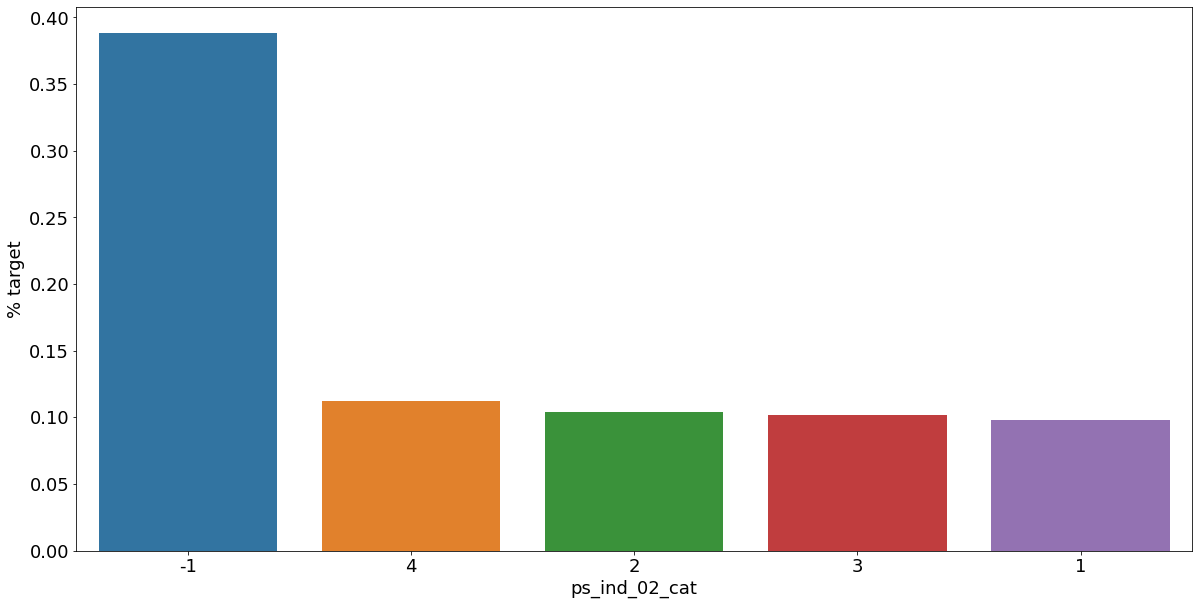

<Figure size 432x288 with 0 Axes>

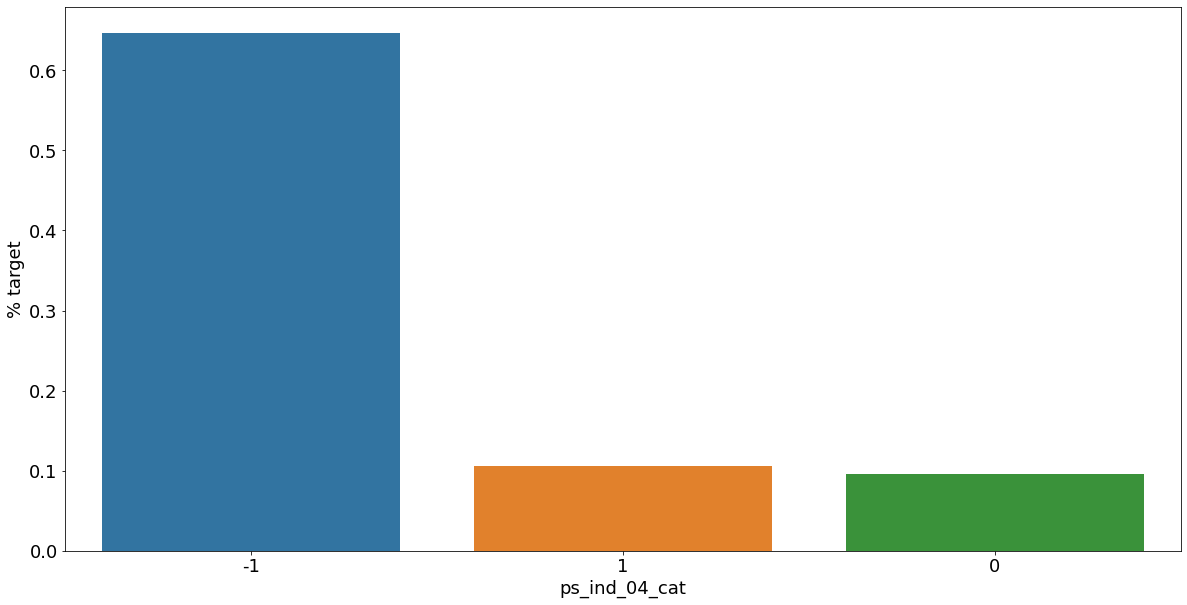

<Figure size 432x288 with 0 Axes>

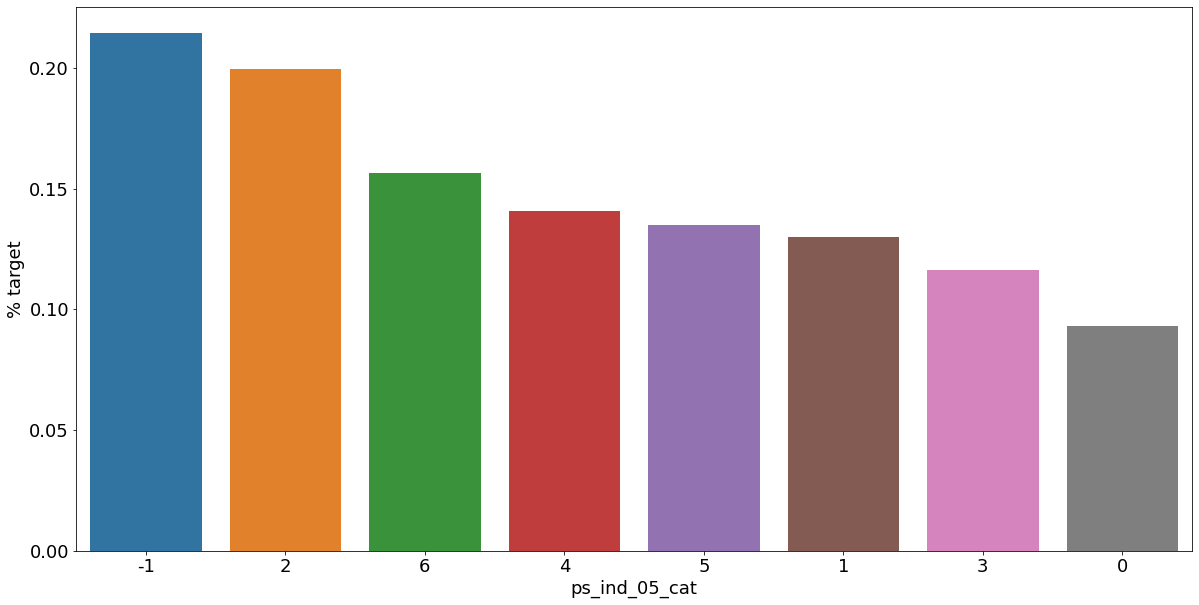

<Figure size 432x288 with 0 Axes>

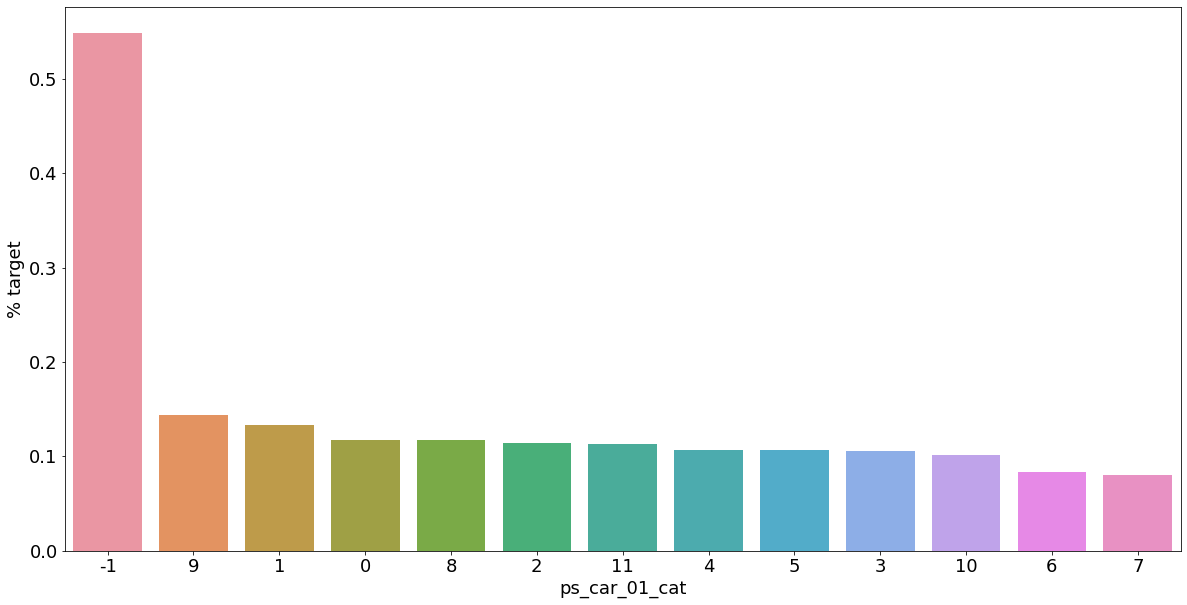

<Figure size 432x288 with 0 Axes>

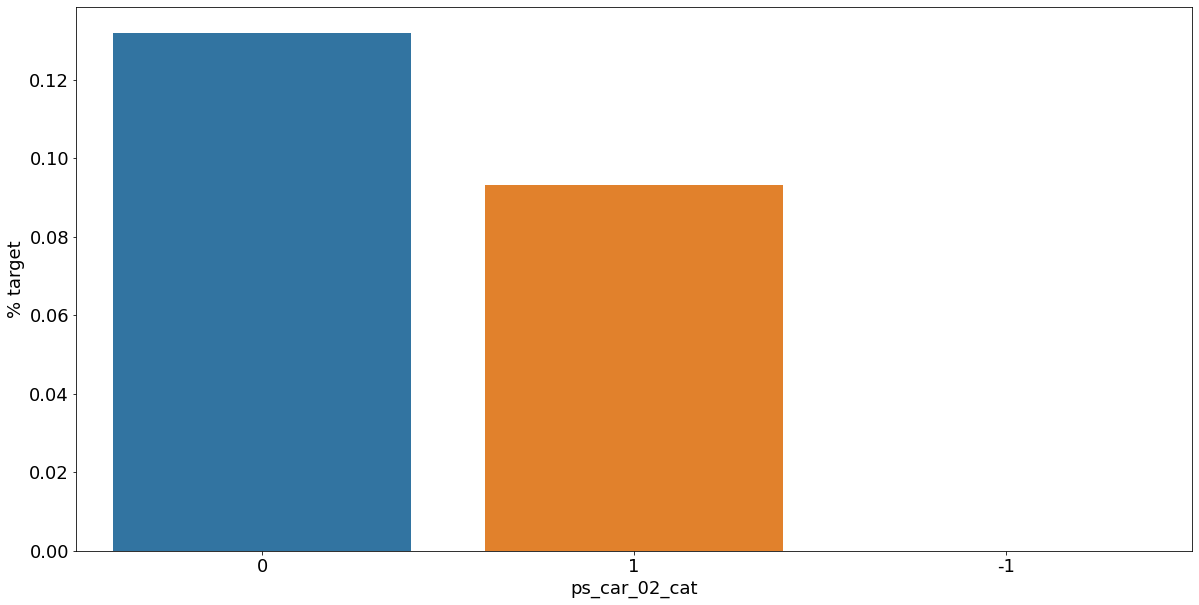

<Figure size 432x288 with 0 Axes>

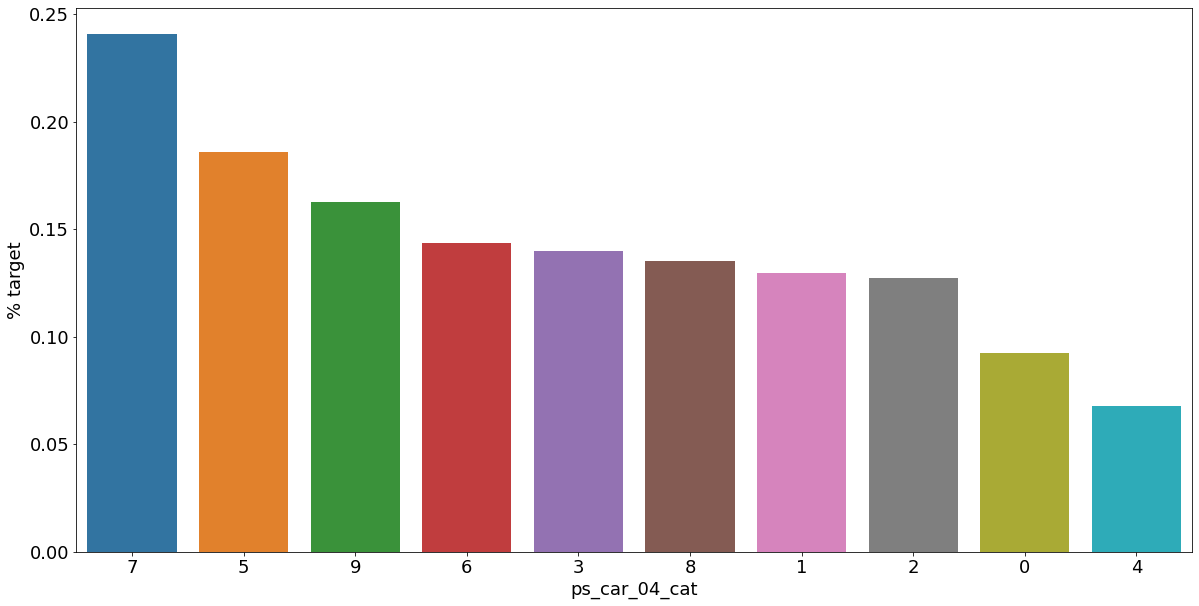

<Figure size 432x288 with 0 Axes>

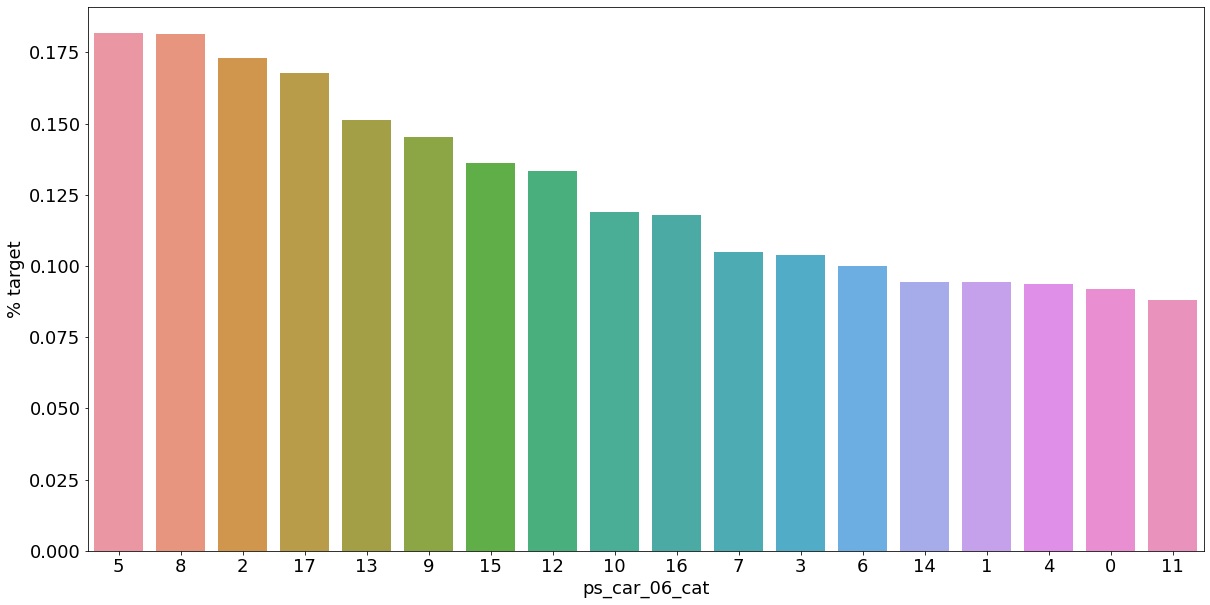

<Figure size 432x288 with 0 Axes>

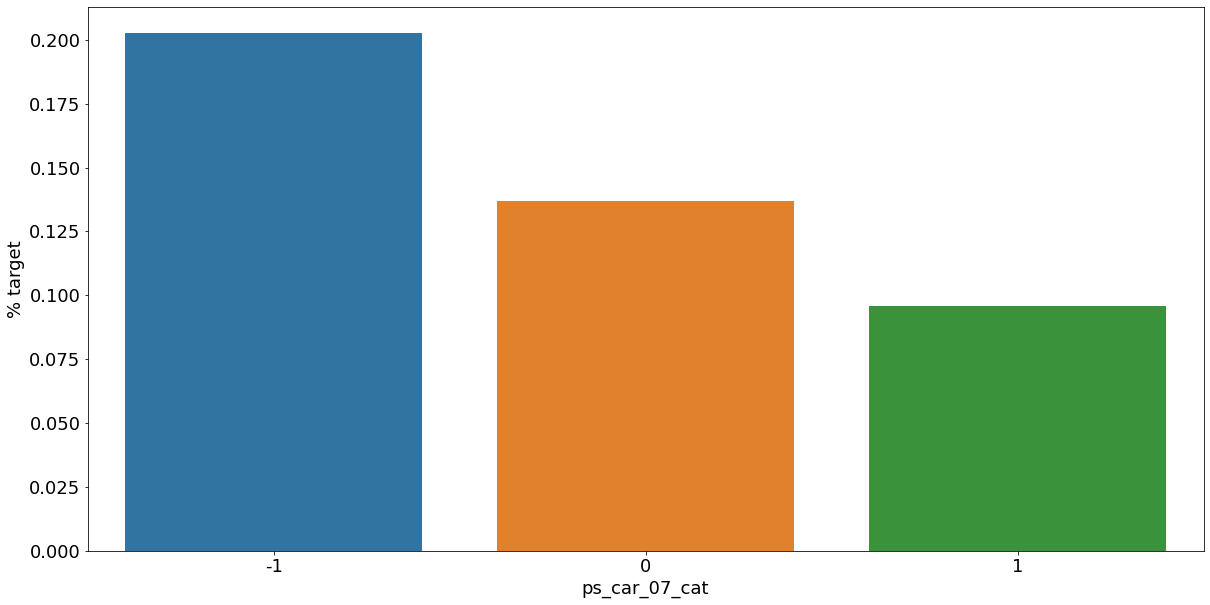

<Figure size 432x288 with 0 Axes>

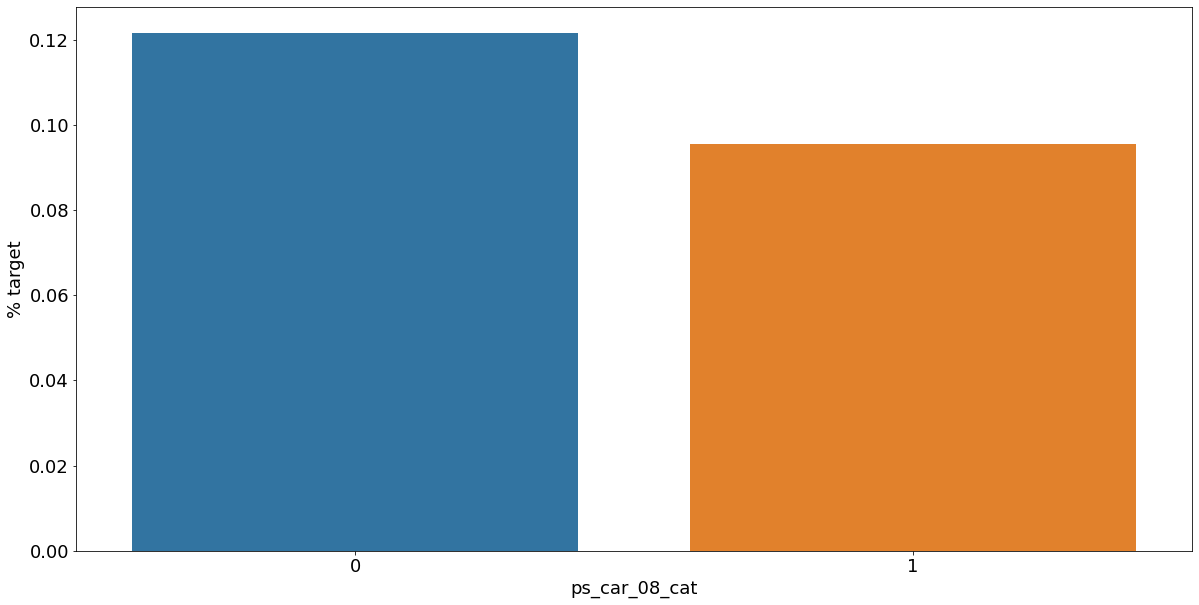

<Figure size 432x288 with 0 Axes>

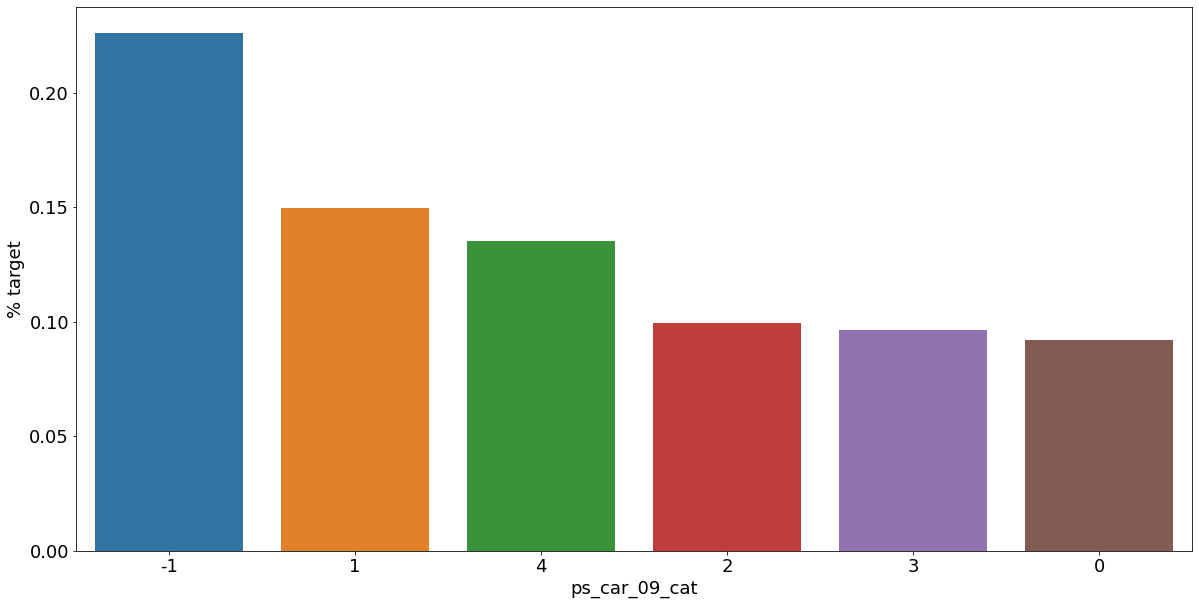

<Figure size 432x288 with 0 Axes>

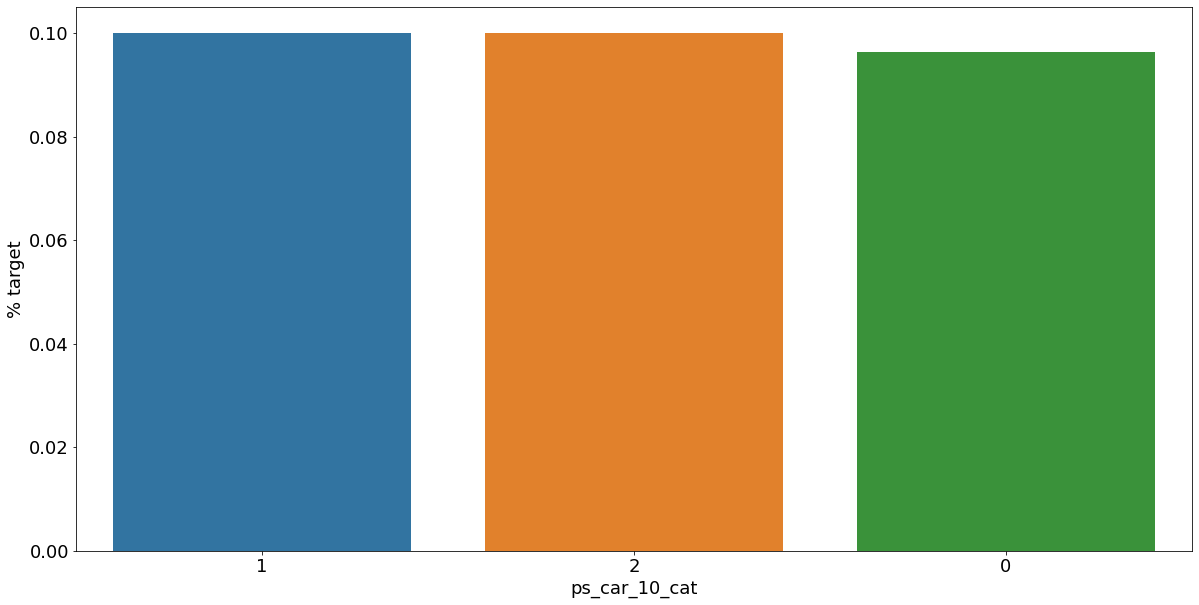

In [26]:
v = meta[(meta.level == 'norminal') & (meta.keep)].index

for f in v:
  plt.figure()
  fig, ax = plt.subplots(figsize=(20,10))

  cat_prec = train[[f,'target']].groupby([f], as_index=False).mean()
  cat_prec.sort_values(by = 'target', ascending=False, inplace=True)

  sns.barplot(ax=ax, x=f, y='target', data=cat_prec, order=cat_prec[f])
  plt.ylabel('% target', fontsize=18)
  plt.xlabel(f, fontsize=18)
  plt.tick_params(axis='both', which='major', labelsize=18)
  plt.show()

일부 카테고리에서 결측값들이 다른 value들에 비해 **훨씬 높은 target 평균을 가지고 있다.**

0.5면 애매하다. 차라리 크거나 작으면 판단하기 수월. 

하지만 정확히 결측치가 몇개인지 나와있지 않기에 잘못된 인사이트를 얻을 수 있다.

In [27]:
f = 'ps_car_02_cat'
cat_prec = train[[f,'target']].groupby([f], as_index=False).agg(['mean', 'count'])
cat_prec

target        
                   mean   count
ps_car_02_cat                  
-1             0.000000       2
 0             0.131868   38000
 1             0.093233  178938

결측치가 2개 밖에 없다. 그림에서 결측치는 1일 확률이 거의 0이었는데, 2개밖에 없기에 믿을만한 결과는 아니다. **즉, count가 몇개인지 그림에 표시하자!**

해당 커널에서는 -1이 어느정도 정보를 가지고 있다고 판단하고 그대로 둔다.

**Interval variables**

해당 코드는 [an example by Michael Waskom](http://seaborn.pydata.org/examples/many_pairwise_correlations.html)에 기반한 코드.

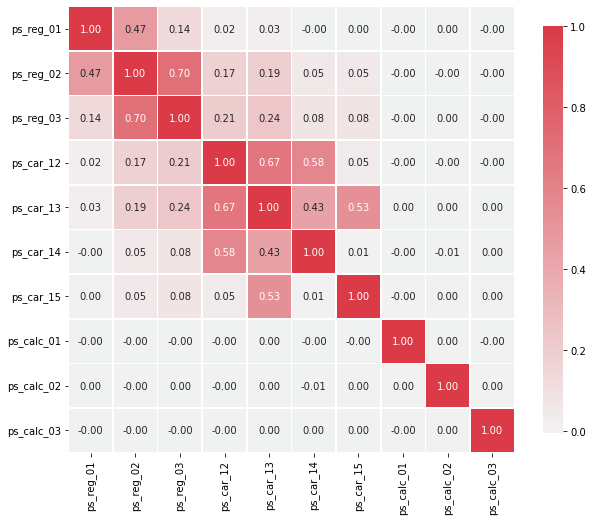

In [28]:
def corr_heatmap(v):
  correlations = train[v].corr()

  # 팔레트 정하는 코드.
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  fig, ax = plt.subplots(figsize=(10,10))
  # square = True 각 네모들 정사각형으로 만들어 준다.
  sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
              square=True, linewidths=.5, annot=True, cbar_kws={'shrink':.75})
  plt.show()

v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

강한 상관관계를 가지고 있는 Variables는 다음과 같다.

- ps_reg_02 and ps_reg_03 (0.7)
- ps_car_12 and ps_car13 (0.67)
- ps_car_12 and ps_car14 (0.58)
- ps_car_13 and ps_car15 (0.67)

상관관계가 강한 변수들의 pair plot을 본다.

속도를 높이기 위해 train 데이터의 샘플을 사용한다.

In [29]:
s = train.sample(frac=0.1)

### 1. ps_reg_02 and ps_reg_03 (0.7)

두 변수들 간의 선형 상관관계를 볼 수 있다. target = 0, target = 1에 대한 회귀선이 동일한 걸 알 수 있다.

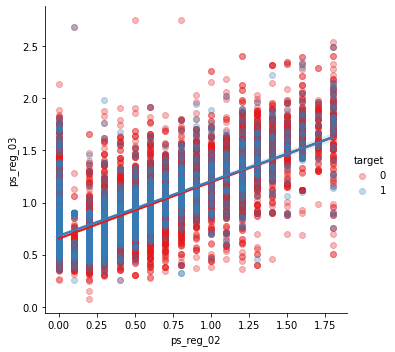

In [30]:
# lmplot -> regression plot 그려준다.
# alpha 는 투명도를 의미
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette ='Set1',
           scatter_kws={'alpha':0.3})
plt.show()

### ps_car_12 and ps_car_13 (0.67)

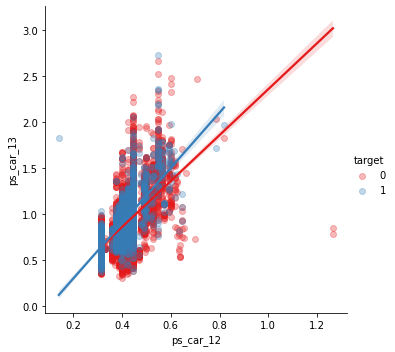

In [31]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ps_car_12 and ps_car_14 (0.58)

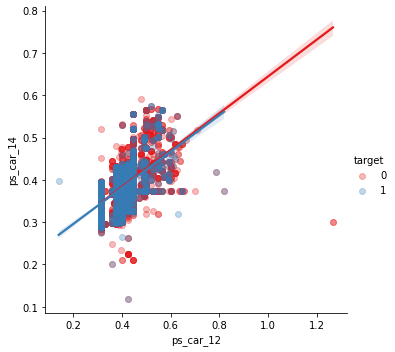

In [32]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ps_car_13 and ps_car_15 (0.67)

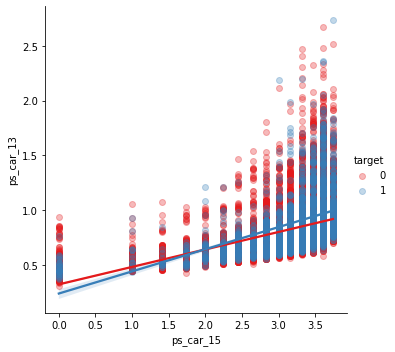

In [33]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

***그림을 그리는 이유 corr 숫자는 왜곡될 수도 있다. 즉, 그림을 그려봐서 해당 기울기 값이 왜곡되지 않았는지 확인해야 한다. 즉, 데이터포인트가 진짜로 선형으로 되어있는지 없는데 왜곡된 건지 확인을 해야한다.***

어떤 correlated variables를 유지할지 결정해야한다. 이를 위해 **PCA, 주성분 분석**을 실시하여 변수의 차원을 줄인다. 하지만, correlated variables 수가 적은만큼, 모델이 heavy-lifting을 하도록 해야한다.

(PCA 하기전에 StandardScaler를 반드시 해야 한다. -> 각 특성의 분산이 가장 큰 방향으로 틀어져서 보는 건데, 데이터들의 분산이 너무 다르면 왜곡이 될 수 있기 때문. )

**Checking the correlations between ordinal variables**

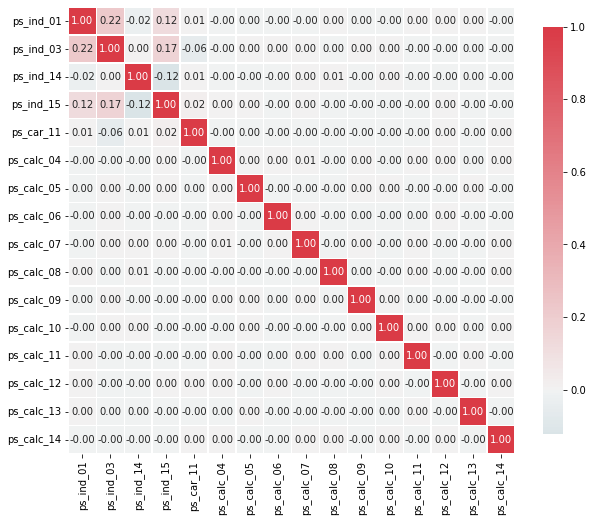

In [34]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

ordinal 변수들은 큰 상관관계를 가지고 있지 않은 걸로 보인다.

## Feature engineering

**Creating dummy variables** <br>

categorical 변수는 어떤 순서나 경중이 담겨있지 않다. 예를 들어 카테고리 2는 카테고리 1보다 2배의 값을 가지고 있지 않다. 이러한 문제는 더미 데이터를 만들어줌으로써 해결할 수 있다. 첫번째 더미 변수의 정보는 원래 변수의 범주에 대해 생성된 다른 더미 변수에서 파생될 수 있으므로 삭제해주도록 한다. 

*예를 들어, 3개의 종류가 있는 카테고리 피쳐인 경우* ***2개만 사용해도 3개를 사용한 것과 동일한 의미를 전달할 수 있다.***

In [35]:
v = meta[(meta.level == 'norminal') & (meta.keep)].index
print('Befor dummification we have {} variavles in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns = v, drop_first=True)
print('After dummification we have {} variavles in train'.format(train.shape[1]))

Befor dummification we have 57 variavles in train
After dummification we have 109 variavles in train


**Creating interaction variables**

In [36]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns = poly.get_feature_names(v))
# poly 처리가 되지 않은 기존의 열들을 삭제
interactions.drop(v, axis=1, inplace=True)

print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train,interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 164 variables in train


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


PolynomialFeatures는 다항차수 변환 진행을 도와주는 클래스이다. 위 코드의 경우 degree를 2로 설정했으니 2차항 변수로 만들어주는 것이다. interaction_only=True면, 자기 자신의 제곱은 없음. include_bias=False는 interaction 한 후 bias는 포함 X.

예를 들어 키와 몸무게가 있을 경우 둘을 곱해줘서 새로운 특성을 만들거나 하는 경우.

## Feature selection

**Removing features with low or zero variance**

사이킷런의 VarianceThreshold를 사용하여 분산이 0이거나 아주 적은 features들을 제거한다.

하지만, 이전 단계에서 분산이 0인 features가 없는 걸 확인했기 때문에, 1% 미만의 분산이 있는 features를 제거한다.

In [37]:
selector = VarianceThreshold(threshold=.01)
# id와 target은 제외하고 fit
selector.fit(train.drop(['id', 'target'], axis=1))

# selector.get_support() 하면 threshold 보다 크면 True, 적으면 False
# 이걸 반대로 해주는 것. 분산이 낮은 특성이 뭔지 확인하기 위해.
# ~selector.get_support() 해도 동일한 결과 나옴.
f = np.vectorize(lambda x : not x)

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


분산에 기반해서 진행하면 많은 변수를 일게 된다. 하지만, 가진 변수가 많지 않기 때문에 분류기가 직접 선택하게 하자.

사이킷런은 [feature selecetion methods]를 제공한다. 이 메소드 중 하나가 'SelectFromModel'인데, 다른 분류기에서 최상의 feature를 선택하고 기능을 계속할 수 있도록 한다.

아래 코드는 [GitHub repo of Sebastian Raschka](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch04/ch04.ipynb)에서 가져온 것임.

**Selecting features with a Random Forest and SelectFromModel**

랜덤포레스트의 feature importances에 따라 Feature 선택의 기준을 삼는다.
SelectFromModel을 통하여 유지할 variables의 숫자를 구체화할 수 있다. feature의 중요도에 대한 임곗값을 수동으로 설정할수 있지만, 단순히 50% 이상의 최적의 variables를 선택해보도록 하자.

In [39]:
# n_estimators와 train 개수는 빠르게 하기 위해 조정.
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)

rf.fit(X_train[:1000], y_train[:1000])
importances = rf.feature_importances_

# np.argsort 정렬하고 인덱스 반환해주는 것
indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
  print("%2d %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_calc_03^2                   0.000000
 2) ps_calc_18_bin                 0.000000
 3) ps_car_01_cat_1                0.000000
 4) ps_car_01_cat_0                0.000000
 5) ps_ind_05_cat_6                0.000000
 6) ps_ind_05_cat_5                0.000000
 7) ps_ind_05_cat_4                0.000000
 8) ps_ind_05_cat_3                0.000000
 9) ps_ind_05_cat_2                0.000000
10) ps_ind_05_cat_1                0.000000
11) ps_ind_05_cat_0                0.000000
12) ps_ind_04_cat_1                0.000000
13) ps_ind_04_cat_0                0.000000
14) ps_ind_02_cat_4                0.000000
15) ps_ind_02_cat_3                0.000000
16) ps_ind_02_cat_2                0.000000
17) ps_ind_02_cat_1                0.000000
18) ps_car_11_cat_te               0.000000
19) ps_calc_20_bin                 0.000000
20) ps_car_01_cat_2                0.000000
21) ps_car_01_cat_3                0.000000
22) ps_car_01_cat_4                0.000000
23) ps_car_04_cat_1             

너무 적게해서 특성 중요도가 안 나옴, 커널에서는 타겟 인코딩 한 것이 가장 높게 나왔음.

In [ ]:
# prefit=True 면, 이미 학습한 모델을 주겠다. 안하면 새로 학습을 한다.
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transfrom(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

In [ ]:
train = train[selected_vars + ['target']]

## Feature scaling

train 데이터에 정규화를 진행.

In [ ]:
scaler = StandardScaler()
scaler.fit_transfrom(train.dop['target'], axis=1)